In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [6]:
def microstructure_sumd(df, window=20):
    """
    改进5：融合订单流不平衡
    金融逻辑：结合taker买卖比例和价格变动方向
    改进点：量价关系中引入订单流不平衡因子
    """
    close = df['close']
    price_diff = close.diff()
    
    # 计算订单流不平衡
    buy_ratio = df['taker_buy_volume'] / df['volume'].replace(0, 1e-12)
    ofi = (buy_ratio - 0.5) * df['volume']
    
    # 量价协同指标 - 保持为pandas Series
    gain = pd.Series(np.where(price_diff > 0, price_diff * (1 + ofi), 0), index=df.index)
    loss = pd.Series(np.where(price_diff < 0, -price_diff * (1 - ofi), 0), index=df.index)
    
    sum_gain = gain.rolling(window).sum()
    sum_loss = loss.rolling(window).sum()
    
    # 波动率调整
    atr = ta.atr(df['high'], df['low'], close, length=window)
    factor = (sum_gain - sum_loss) / (atr + 1e-12)
    
    return factor

# 因子测试

In [7]:
evaluator.set_factor(
    factor_func=microstructure_sumd,
    factor_name='microstructure_sumd'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.006901
   Rank_IC (Spearman): -0.034140
📊 信息比率:
   IR: -0.073450
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130920
   因子列: microstructure_sumd
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


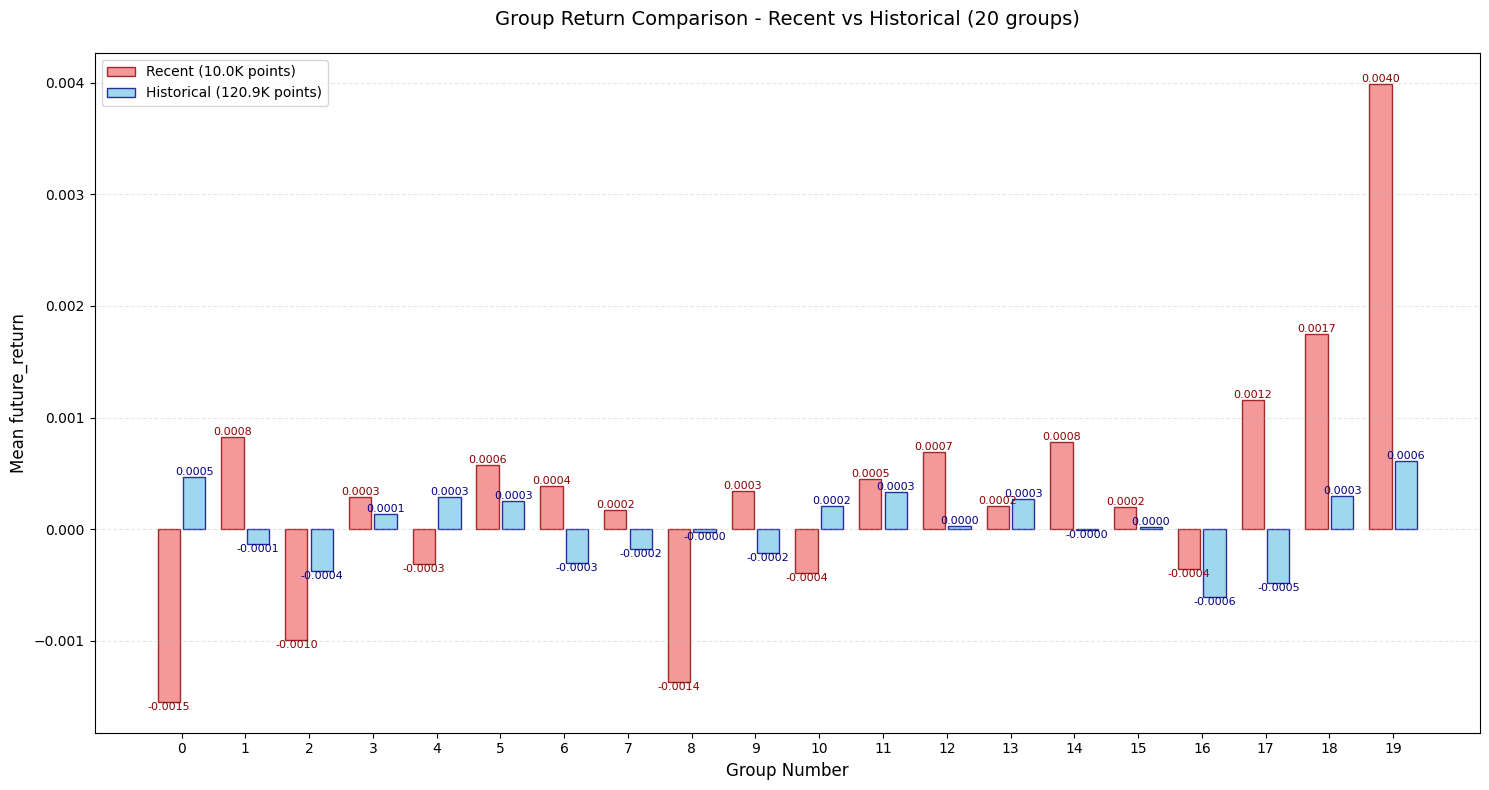

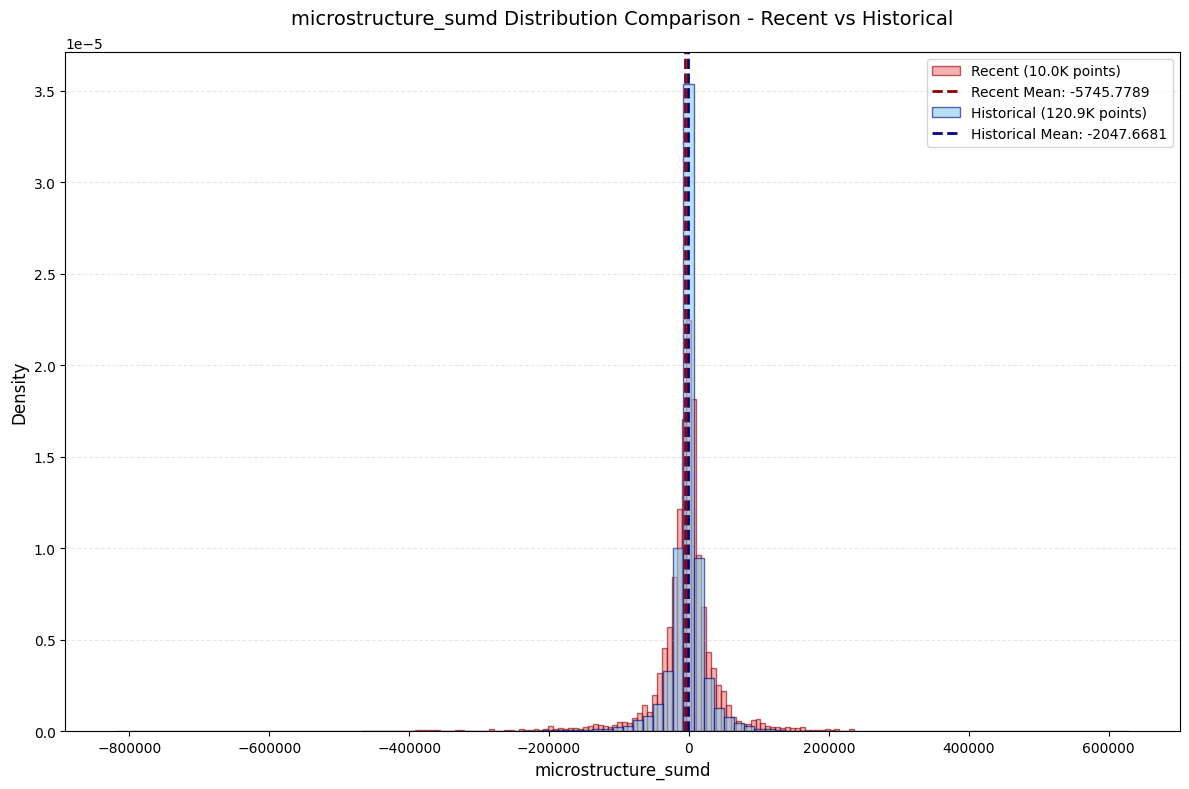

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [8]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [9]:
print(result)

{'correlation_analysis': {'IC': 0.006900615034095835, 'Rank_IC': -0.03413969030774596}, 'information_ratio': {'IR': -0.07345027794690351, 'group_correlations': [-0.019250833471548528, 0.009565470890347547, 0.0012174649210800765, 0.003367425857384574, -0.007272836248939255, -0.00019629504988714482, -0.0012409191250444234, -0.02556399910003636, 0.0015721415362940348, 0.027583120282567937], 'n_groups': 10}, 'group_analysis': {'group_stats':            val_min     val_max     val_mean  return_mean  return_std  count
group                                                                      
0     -819137.9467 -47347.2910 -104257.4129       0.0003      0.0157   6546
1      -47332.4495 -25961.8139  -34536.3942      -0.0001      0.0123   6546
2      -25961.3993 -17716.7443  -21382.8793      -0.0003      0.0134   6546
3      -17714.0282 -12304.1882  -14849.7422       0.0001      0.0127   6546
4      -12304.1686  -8756.3358  -10438.9865       0.0003      0.0121   6546
5       -8756.2636  -6240.